In [26]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from pathlib import Path
from tqdm import tqdm

In [17]:
import sys
sys.path.insert(0, '../../')
from utils.general import  *

In [19]:
def shrink_image(img_path, label_path, kernel_size=2, avg_bbox_size=16272):
    bbox_sizes = []
    img = cv.imread(img_path)
    labels = pd.DataFrame({'class':[],'segment':[]})
    kernel = np.ones((kernel_size, kernel_size), dtype=float) / kernel_size**2

    with open(label_path) as f:
        for line in f:
            split_line = line.split(' ')
            cl = int(split_line[0])
            segment = np.array(split_line[1:], dtype=float)
            row = pd.DataFrame({'class':cl, 'segment': [segment]})
            labels = pd.concat([labels, row], ignore_index=True)
    
    while True: 
        bbox_sizes = []
        mean_img = cv.filter2D(img, -1, kernel)
        smaller_img = mean_img[::kernel_size, ::kernel_size]
        ysize = smaller_img.shape[0]
        xsize = smaller_img.shape[1]
        for idx, row in labels.iterrows():
            segment = row['segment']
            segment = segment.reshape(-1, 2)
            bbox = segment2box(segment)
            x, y, w, h = bbox
            w*=xsize
            h*=ysize
            bbox_sizes.append(w*h)
        img = smaller_img
        bbox_mean = np.mean(bbox_sizes)
        if bbox_mean < avg_bbox_size:
            break

    return img, labels

In [7]:
train_img_dir = Path('/home/isaacp/research/repos/yolov7/coco_mean_pooling/images/train2017')
train_label_dir = Path('/home/isaacp/research/repos/yolov7/coco_mean_pooling/labels/train2017')
img_dir = train_img_dir.iterdir()
# label_dir = os.listdir(train_label_dir)

In [15]:
img_path = Path(next(iter(img_dir)))
label_path = train_label_dir / img_path.name.replace('.jpg','.txt')

In [20]:
img, labels = shrink_image(img_path, label_path)

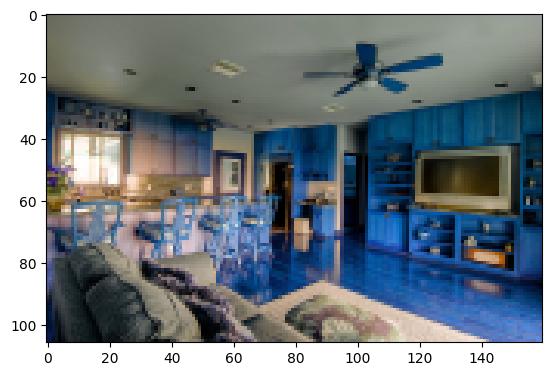

In [21]:
plt.imshow(img)
plt.show()

In [23]:
new_train_dir = Path('../small_train2017')
new_train_dir.mkdir(parents=True, exist_ok=True)
new_label_dir = Path('../small_label2017')
new_label_dir.mkdir(parents=True, exist_ok=True)

In [24]:
new_file_name = img_path.name.replace('.jpg', 'sm')
new_img_path = new_train_dir / (new_file_name + '.jpg')
new_label_path = new_label_dir / (new_file_name + '.txt')
cv2.imwrite(new_img_path, img)
shutil.copy(label_path, new_label_path)

PosixPath('../small_label2017/000000329613sm.txt')

In [50]:
def create_small_train_imgs(old_train_path, 
                            old_label_path, 
                            new_train_path, 
                            new_label_path, 
                            num_imgs, 
                            avg_bbox_size=16272):


    new_train_path = Path(new_train_path)
    new_label_path = Path(new_label_path)

    if not new_train_path.exists():
        new_train_path.mkdir(parents=True, exist_ok=True)

    if not new_label_path.exists():
        new_label_path.mkdir(parents=True, exist_ok=True)
        
    train_img_path = Path(old_train_path)
    train_label_path = Path(old_label_path)
    img_dir_list = os.listdir(train_img_path)

    for _ in tqdm(range(num_imgs)):
        img_path = train_img_path / Path(np.random.choice(img_dir_list, replace=False))
        label_path = train_label_path / img_path.name.replace('.jpg','.txt')
        small_img, small_labels = shrink_image(img_path, label_path)

        new_file_name = img_path.name.replace('.jpg', 'sm')
        small_img_train_path = new_train_path / (new_file_name + '.jpg')
        small_img_label_path = new_label_path / (new_file_name + '.txt')
        cv2.imwrite(small_img_train_path, small_img)
        shutil.copy(label_path, small_img_label_path)

In [51]:
train_img_dir = '/home/isaacp/research/repos/yolov7/coco_mean_pooling/images/train2017'
train_label_dir = '/home/isaacp/research/repos/yolov7/coco_mean_pooling/labels/train2017'
new_train_dir = '../small_train2017'
new_label_dir = '../small_label2017'
num_images = 100

create_small_train_imgs(train_img_dir, train_label_dir, new_train_dir, new_label_dir, num_images)

100%|██████████| 100/100 [00:01<00:00, 90.80it/s]
